2023/08/13

# 概要

- PyTorch (+GPU) の環境構築手順とサンプルコード
- 対応OS: Windows/Ubuntu
  - 同じハード構成でもほぼ間違いなくUbuntuのほうが高速

# 環境構築


## 1. NVIDIA driver のインストール

### Windowsの場合
- [GeForce Experience アプリ](https://www.nvidia.com/ja-jp/geforce/geforce-experience/) を使うと自動で更新通知が来て楽（要ユーザ登録）．
  - ドライバ単体を https://www.nvidia.co.jp/Download/index.aspx?lang=jp から落としてもよい．
- インストール後再起動し，`> nvidia-smi` が動くか確認
### Ubuntuの場合
- `$ ubuntu-drivers devices` で確認できるドライバのうち，末尾にrecommendedと付いている行を確認
- それをインストール：`$ sudo apt install nvidia-driver-xxx`
- インストール後再起動し，`> nvidia-smi` が動くか確認

## 2. PyTorchのインストール
- https://pytorch.org/ で自分の環境に合わせたインストールコマンドを取得し，実行するだけ．
- たとえば Stable (2.0.1) + Pip + Python + CUDA 11.8 なら
```sh
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
- CUDA, cuDNN も一緒に入るのでこいつらはインストール不要．
- 仮想環境での作業を強く推奨．
  - Ubuntuなら `$ python3 -m venv venv; source ./venv/bin/activate` するだけ

# サンプルコード

In [1]:
# バージョン確認．CPU版の場合 "+cu118" のような表記がないことに注意．
import torch
torch.__version__

'2.0.1+cu118'

In [2]:
# CUDAが使えることを確認
torch.cuda.is_available()

True

## データセットの取得
CIFAR10

In [3]:
# データセットの読み込み
from torchvision import datasets, transforms
data_tr = datasets.CIFAR10("~/data/", train= True, transform=transforms.ToTensor(), download=True)
data_te = datasets.CIFAR10("~/data/", train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32])
6


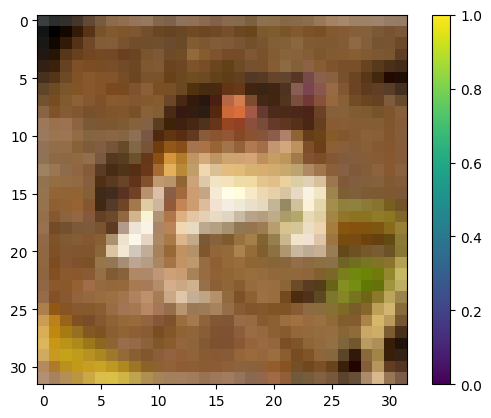

In [4]:
# 最初のデータを確認
x0, y0 = data_tr[0]
print(x0.shape) # 入力：(channels, height, width)
print(y0)       # 出力：整数

# 画像の確認
import matplotlib.pyplot as plt
plt.imshow(x0.permute(1, 2, 0)) # (height, width, channels) に直して描画
plt.colorbar()                  # 画素値∈[0, 1]

In [5]:
# ミニバッチ化
loader_tr = torch.utils.data.DataLoader(data_tr, batch_size=256, shuffle=True)
loader_te = torch.utils.data.DataLoader(data_te, batch_size=256, shuffle=True)

In [6]:
# 最初のバッチを確認（データをバッチサイズ分並べただけ）
for x0, y0 in loader_tr:
    break
print(x0.shape)
print(y0.shape)
print(y0[:5])

torch.Size([256, 3, 32, 32])
torch.Size([256])
tensor([8, 2, 4, 6, 7])


## モデルの作成

In [7]:
# モデル定義
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1  = torch.nn.Conv2d(3, 20, 5, padding=2)
        self.conv2  = torch.nn.Conv2d(20, 40, 5, padding=2)
        self.norm1  = torch.nn.BatchNorm2d(20)
        self.norm2  = torch.nn.BatchNorm2d(40)
        self.pool   = torch.nn.MaxPool2d(2)
        self.output = torch.nn.Linear(40*8*8, 10)

    def forward(self, x):   # x.shape = (bsz, 3, 32, 32)
        x = self.pool(self.norm1(self.conv1(x)).relu()) # (bsz, 20, 16, 16)
        x = self.pool(self.norm2(self.conv2(x)).relu()) # (bsz, 40, 8, 8)
        x = self.output(x.view(len(x), -1))             # (bsz, 10)
        return x

In [8]:
# モデル作成・推論
model = CNN()
p = model(x0)       # p.shape = (bsz, 10)
print(p.argmax(-1)) # 推定ラベル

tensor([4, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 8, 2, 2, 2, 2, 2, 2, 2, 4, 2,
        3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 4, 3, 4, 3, 3, 2, 2, 3, 2, 3, 4, 2, 2,
        3, 3, 4, 2, 4, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2,
        3, 3, 4, 2, 2, 2, 3, 2, 5, 2, 2, 2, 2, 2, 3, 2, 4, 2, 3, 2, 2, 2, 2, 8,
        2, 2, 2, 4, 3, 4, 2, 3, 8, 2, 2, 2, 2, 3, 2, 4, 2, 4, 2, 2, 2, 8, 3, 3,
        2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 9, 2, 3, 2, 2, 4, 2, 3, 2, 3, 2, 2, 2,
        2, 2, 2, 4, 2, 2, 4, 2, 4, 2, 3, 3, 2, 2, 3, 2, 4, 2, 2, 3, 2, 3, 2, 4,
        2, 2, 2, 2, 2, 2, 3, 2, 8, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3,
        4, 2, 2, 6, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 4, 3, 2, 3,
        3, 2, 2, 4, 4, 2, 2, 3, 3, 2, 3, 4, 4, 2, 2, 9, 2, 3, 3, 2, 2, 3, 2, 3,
        2, 2, 4, 2, 2, 2, 8, 8, 2, 4, 2, 2, 3, 2, 4, 3])


## 学習

In [9]:
%%time
model = CNN().cuda()    # .cuda()でGPUメモリへ転送
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(1, 1+10):
    # 訓練
    for batch, (x, y) in enumerate(loader_tr, 1):
        x, y = x.cuda(), y.cuda()   # GPUメモリへ転送
        p = model(x)                # 順伝播
        loss = torch.nn.functional.cross_entropy(p, y)  # 損失計算
        optimizer.zero_grad()       # 勾配初期化
        loss.backward()             # 逆伝播
        optimizer.step()            # 更新
        print(f"\r{epoch:2} epoch ({batch} / {len(loader_tr)} batch)", end="")
        
    # 検証 (全テストデータまとめて)
    p = model(torch.Tensor(data_te.data).cuda().permute(0, 3, 1, 2)/255)
    y = torch.tensor(data_te.targets).cuda()
    loss = torch.nn.functional.cross_entropy(p, y)  # 損失
    acc = (p.argmax(1) == y).float().mean()         # 精度
    print(f" - loss: {loss:.4f} - acc: {acc:.4f}")

/home/kikulab/abc/venvs/venv311/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


 1 epoch (196 / 196 batch) - loss: 1.1606 - acc: 0.5926
 2 epoch (196 / 196 batch) - loss: 1.0335 - acc: 0.6331
 3 epoch (196 / 196 batch) - loss: 0.9892 - acc: 0.6548
 4 epoch (196 / 196 batch) - loss: 0.8887 - acc: 0.6937
 5 epoch (196 / 196 batch) - loss: 0.8852 - acc: 0.6984
 6 epoch (196 / 196 batch) - loss: 0.8470 - acc: 0.7072
 7 epoch (196 / 196 batch) - loss: 0.8700 - acc: 0.6945
 8 epoch (196 / 196 batch) - loss: 0.8575 - acc: 0.7041
 9 epoch (196 / 196 batch) - loss: 0.8265 - acc: 0.7173
10 epoch (196 / 196 batch) - loss: 0.8128 - acc: 0.7215
CPU times: user 18.5 s, sys: 748 ms, total: 19.2 s
Wall time: 15.8 s
